In [ ]:
import pandas as pd
import os
from pyproj import Transformer
import numpy as np
import folium
from folium.plugins import MarkerCluster, HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from datetime import datetime

# 1. Limpiar datos erróneos en dataset de Autobuses EMT

## Convertir Separador CSV - Autobuses EMT

Este notebook convierte el archivo `stopsemt.csv` de separador coma (`,`) a punto y coma (`;`) para evitar problemas con campos que contienen comas dentro de comillas.

**Input**: `data/AUTOBUSES/stopsemt.csv` (separador: `,`)

**Output**: `data/AUTOBUSES/stopsemt_clean.csv` (separador: `;`)

In [3]:
df = pd.read_csv("data/AUTOBUSES/stopsemt.csv", sep=",", quotechar='"')
df.to_csv("data/AUTOBUSES/stopsemt_clean.csv", sep=";", index=False, quotechar='"')

## Conversión de Coordenadas UTM a Lat/Long
- **Sistema origen**: UTM Zone 30N (EPSG:25830) - coordenadas proyectadas en metros
- **Sistema destino**: WGS84 (EPSG:4326) - coordenadas geográficas en grados decimales
- **Transformación**: Usa `pyproj.Transformer` para conversión precisa
- **Campos afectados**: `posX` (Este → Longitud), `posY` (Norte → Latitud)

In [4]:
autobuses = pd.read_csv('data/AUTOBUSES/stopsemt_clean.csv', sep=';')

transformer = Transformer.from_crs("EPSG:25830", "EPSG:4326", always_xy=True)

lon, lat = transformer.transform(
    autobuses['posX'].values, 
    autobuses['posY'].values
)

autobuses['posX'] = lon
autobuses['posY'] = lat

autobuses.to_csv('data/AUTOBUSES/stopsemt_clean_coordinates_converted.csv', sep=';', index=False)

# Cargar los datos limpios (salida de hop)

In [3]:
df_metro = pd.read_csv('resultados/metro_procesado.csv', sep=';')
df_autobuses = pd.read_csv('resultados/autobuses_procesado.csv', sep=';')
df_bicimad = pd.read_csv('resultados/bicimad_procesado.csv', sep=';')
df_parkings = pd.read_csv('resultados/parkings_procesado.csv', sep=';')

df_all = pd.read_csv('resultados/transporte_madrid_consolidado.csv', sep=';')

In [ ]:
df_metro.head()

,stop_id,stop_name,stop_lat,stop_lon,transport_mode
0,par_4_1,PLAZA DE CASTILLA,40.46690,-3.68917,metro
1,acc_4_1_1,Plaza de Castilla,40.46682,-3.68918,metro
2,acc_4_1_1040,Ascensor,40.46555,-3.68877,metro
3,acc_4_1_1043,Intercambiador Superficie,40.46728,-3.68915,metro
4,acc_4_1_1044,Ascensor,40.46702,-3.68918,metro


In [7]:
df_autobuses.head()

,stop_id,stop_name,bus_line,stop_lon,stop_lat,transport_mode
0,4514,Cristo Rey ...,1,-3.716655,40.440258,bus
1,4022,Junta Municipal Moncloa ...,1,-3.717145,40.437624,bus
2,3687,Moncloa ...,1,-3.716809,40.435924,bus
3,737,Altamirano ...,1,-3.716282,40.433990,bus
4,735,Argüelles ...,1,-3.714798,40.431936,bus


In [8]:
df_bicimad.head()

,station_id,station_name,stop_lon,stop_lat,state,capacity,transport_mode
0,2,Metro Callao,-3.705690,40.420400,IN_SERVICE,27,bicimad
1,3,Plaza Conde Suchil,-3.707254,40.430322,IN_SERVICE,19,bicimad
2,4,Malasaña,-3.702500,40.428626,IN_SERVICE,27,bicimad
3,5,Fuencarral,-3.702135,40.428521,IN_SERVICE,27,bicimad
4,6,Colegio de Arquitectos,-3.699023,40.423178,IN_SERVICE,19,bicimad


In [36]:
df_parkings.head()

,parking_id,parking_name,stop_lat,stop_lon,standard_spaces,pmr_spaces,PMR_ratio,transport_mode,capacity
0,2,Colón,40.424709,-3.689939,1047,21,0.020057,parking,247
1,3,Corazón de María II,40.438525,-3.645525,327,0,0.000000,parking,216
2,4,Encuentro,40.405465,-3.651354,104,0,0.000000,parking,95
3,5,Nuestra Señora del Recuerdo,40.472181,-3.679160,902,12,0.013304,parking,183
4,6,Corona Boreal,40.456800,-3.783200,120,0,0.000000,parking,339


In [10]:
df_all.head()

,stop_name,stop_lat,stop_lon,transport_mode,stop_id
0,PLAZA DE CASTILLA ...,40.46690,-3.68917,metro ...,par_4_1 ...
1,Plaza de Castilla ...,40.46682,-3.68918,metro ...,acc_4_1_1 ...
2,Ascensor ...,40.46555,-3.68877,metro ...,acc_4_1_1040 ...
3,Intercambiador Superficie ...,40.46728,-3.68915,metro ...,acc_4_1_1043 ...
4,Ascensor ...,40.46702,-3.68918,metro ...,acc_4_1_1044 ...


In [5]:
print(f"Metro: {len(df_metro)} paradas")
print(f"Autobuses: {len(df_autobuses)} paradas")
print(f"BiciMAD: {len(df_bicimad)} estaciones")
print(f"Parkings: {len(df_parkings)} parkings")

Metro: 1050 paradas
Autobuses: 12430 paradas
BiciMAD: 626 estaciones
Parkings: 82 parkings


## Análisis de cobertura

In [13]:
OUTPUT_MAP = 'resultados/mapa_cobertura.html'

def calcular_densidad(metro, bus, bici, parkings):
    print("\nCalculando densidad de estaciones...")
    STEP = 0.0045
    
    bici_aux = bici.rename(columns={'station_name': 'stop_name'})
    
    df_all = pd.concat([
        metro[['stop_lat', 'stop_lon']],
        bus[['stop_lat', 'stop_lon']],
        bici_aux[['stop_lat', 'stop_lon']],
        parkings[['stop_lat', 'stop_lon']]
    ])
    
    df_all['lat_bin'] = (df_all['stop_lat'] / STEP).round().astype(int)
    df_all['lon_bin'] = (df_all['stop_lon'] / STEP).round().astype(int)
    
    density = df_all.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')
    density['lat_center'] = density['lat_bin'] * STEP
    density['lon_center'] = density['lon_bin'] * STEP
    
    print("Top 10 zonas con mayor densidad de transporte:")
    print(density.sort_values('count', ascending=False).head(10))
    return density

def crear_mapa(metro, bus, bici, parkings):
    print("\nGenerando mapa...")
    m = folium.Map(location=[40.416775, -3.703790], zoom_start=12, tiles='CartoDB positron')
    
    # Capas
    layer_metro = folium.FeatureGroup(name='Metro (Azul)')
    layer_bus = folium.FeatureGroup(name='Autobús (Verde)')
    layer_bici = folium.FeatureGroup(name='BiciMAD (Rojo)')
    layer_parkings = folium.FeatureGroup(name='Parkings (Naranja)')
    
    # Añadir puntos Metro
    for idx, row in metro.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=4,
            color='blue',
            fill=True,
            fill_opacity=0.7,
            popup=f"Metro: {row['stop_name']}"
        ).add_to(layer_metro)
        
    # Añadir puntos Bus
    for idx, row in bus.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=2,
            color='green',
            fill=True,
            fill_opacity=0.5,
            popup=f"Bus: {row['stop_name']}"
        ).add_to(layer_bus)
        
    # Añadir puntos Bici
    for idx, row in bici.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.6,
            popup=f"Bici: {row['station_name']}"
        ).add_to(layer_bici)
    
    # Añadir puntos Parkings
    for idx, row in parkings.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=5,
            color='orange',
            fill=True,
            fill_opacity=0.8,
            popup=f"Parking: {row['parking_name']}"
        ).add_to(layer_parkings)

    layer_metro.add_to(m)
    layer_bus.add_to(m)
    layer_bici.add_to(m)
    layer_parkings.add_to(m)
    
    folium.LayerControl().add_to(m)
    
    m.save(OUTPUT_MAP)
    print(f"Mapa guardado en: {OUTPUT_MAP}")


calcular_densidad(df_metro, df_autobuses, df_bicimad, df_parkings)
crear_mapa(df_metro, df_autobuses, df_bicimad, df_parkings)
print("Análisis completado.")


Calculando densidad de estaciones...
Top 10 zonas con mayor densidad de transporte:
     lat_bin  lon_bin  count  lat_center  lon_center
474     8980     -820    122     40.4100     -3.6900
645     8986     -826     91     40.4370     -3.7170
549     8983     -824     87     40.4235     -3.7080
553     8983     -820     80     40.4235     -3.6900
313     8976     -821     74     40.3920     -3.6945
527     8982     -821     69     40.4190     -3.6945
551     8983     -822     67     40.4235     -3.6990
528     8982     -820     66     40.4190     -3.6900
548     8983     -825     65     40.4235     -3.7125
833     8991     -817     61     40.4595     -3.6765

Generando mapa...
Mapa guardado en: resultados/mapa_cobertura.html
Análisis completado.


### Análisis multimodal

In [29]:
# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 24) # Hacemos el lienzo grande para que quepan todas
plt.rcParams['font.size'] = 11

# Factor de conversión aproximado para Madrid (grados a metros)
FACTOR_LAT = 111000
FACTOR_LON = 111000 * np.cos(np.radians(40.4))

def get_coords_meters(df):
    coords = df[['stop_lat', 'stop_lon']].values.copy()
    coords[:, 0] *= FACTOR_LAT
    coords[:, 1] *= FACTOR_LON
    return coords

# Coordenadas en metros
coords_bicimad = get_coords_meters(df_bicimad)
coords_metro = get_coords_meters(df_metro)
coords_bus = get_coords_meters(df_autobuses)
coords_parking = get_coords_meters(df_parkings)

# --- A. Cálculos para BiciMAD ---
# Distancia al Metro más cercano
dists_bici_metro = cdist(coords_bicimad, coords_metro).min(axis=1)
# Distancia al Bus más cercano
dists_bici_bus = cdist(coords_bicimad, coords_bus).min(axis=1)

df_bicimad_plot = df_bicimad.copy()
df_bicimad_plot['dist_metro'] = dists_bici_metro
df_bicimad_plot['dist_bus'] = dists_bici_bus
# Categoría de integración
df_bicimad_plot['integracion'] = np.where(df_bicimad_plot['dist_metro'] < 300, 'Alta (<300m)', 
                                 np.where(df_bicimad_plot['dist_metro'] < 600, 'Media (300-600m)', 'Baja (>600m)'))

# --- B. Cálculos para METRO (Hubs) ---
# Contar cuántos buses y bicis hay cerca de cada metro (Radio 300m)
matrix_metro_bus = cdist(coords_metro, coords_bus)
matrix_metro_bici = cdist(coords_metro, coords_bicimad)

df_metro_plot = df_metro.copy()
df_metro_plot['buses_cercanos'] = (matrix_metro_bus < 300).sum(axis=1)
df_metro_plot['bicis_cercanas'] = (matrix_metro_bici < 300).sum(axis=1)

# Determinar Línea (Si no existe columna, intentamos extraerla o usar placeholder)
if 'Line' not in df_metro_plot.columns:
    # Intento de extracción simple si el nombre es tipo "L1 - Sol"
    # Si no, creamos una ficticia para que el código no falle
    df_metro_plot['Line'] = 'L' + df_metro_plot.index.astype(str).str[-1] 

# Clasificación de multimodalidad
def nivel_multimodal(row):
    modos = 1 # Ya es metro
    if row['buses_cercanos'] > 0: modos += 1
    if row['bicis_cercanas'] > 0: modos += 1
    return f"{modos} Modos"

df_metro_plot['nivel_multimodal'] = df_metro_plot.apply(nivel_multimodal, axis=1)

# --- C. Cálculos para PARKINGS ---
dists_park_metro = cdist(coords_parking, coords_metro).min(axis=1)
df_parking_plot = df_parkings.copy()
df_parking_plot['dist_metro'] = dists_park_metro

# Asegurar columna capacidad (simulada si no existe para evitar error)
if 'capacity' not in df_parking_plot.columns:
    df_parking_plot['capacity'] = np.random.randint(100, 1200, size=len(df_parking_plot))

- Histograma con la frecuencia de estaciones BiciMAD según distancia al metro + histograma con la misma frecuencia para los buses, con opacidad baja para que se puedan ver las superposiciones, si hay

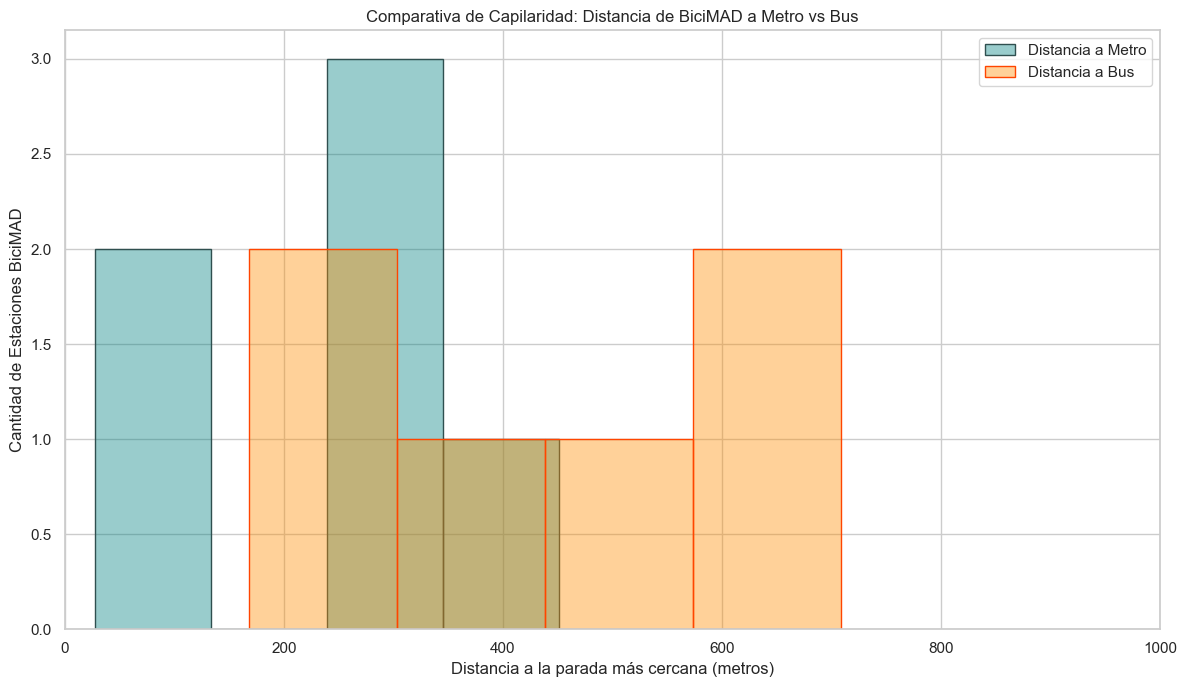

In [28]:
# Configuración específica para este histograma doble
plt.figure(figsize=(12, 7))

# Histograma 1: Distancia a METRO (Azul, transparencia 0.4)
sns.histplot(
    data=df_bicimad_plot, 
    x='dist_metro', 
    color='teal', 
    label='Distancia a Metro', 
    kde=False, 
    alpha=0.4,
    edgecolor='darkslategray'  # Darker teal for the border color
)

# Histograma 2: Distancia a BUS (Naranja, transparencia 0.4)
sns.histplot(
    data=df_bicimad_plot, 
    x='dist_bus', 
    color='darkorange', 
    label='Distancia a Bus', 
    kde=False, 
    alpha=0.4,
    edgecolor='orangered'  # Darker orange for the border color
)

plt.title('Comparativa de Capilaridad: Distancia de BiciMAD a Metro vs Bus')
plt.xlabel('Distancia a la parada más cercana (metros)')
plt.ylabel('Cantidad de Estaciones BiciMAD')
plt.legend()

# Zoom en los primeros 1000m para ver el detalle importante (la "última milla")
plt.xlim(0, 1000)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_multimodal/histograma_comparativo_metro_bus.png', dpi=300)
plt.show()

- Scatter plot. Cada punto es una estación de Metro. Eje X = Nº de paradas de Bus cercanas; Eje Y = Nº de bases BiciMAD cercanas.

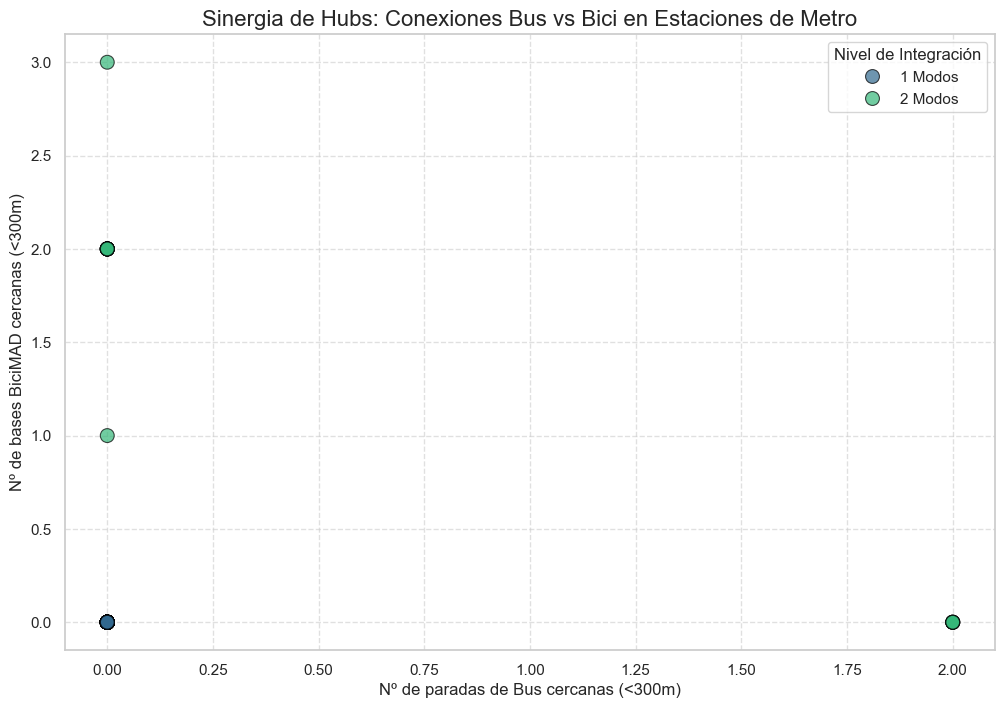

In [32]:
# Configuración del tamaño
plt.figure(figsize=(12, 8))

# Generar el Scatter Plot
# Usamos 'hue' para diferenciar visualmente los nodos que tienen más modos conectados
sns.scatterplot(
    data=df_metro_plot, 
    x='buses_cercanos', 
    y='bicis_cercanas', 
    hue='nivel_multimodal',    # Colorear según multimodalidad (opcional, queda mejor)
    palette='viridis',         
    s=100,                     # Tamaño de los puntos
    alpha=0.7,                 # Transparencia para ver superposiciones
    edgecolor='black'
)

# Títulos y Etiquetas
plt.title('Sinergia de Hubs: Conexiones Bus vs Bici en Estaciones de Metro', fontsize=16)
plt.xlabel('Nº de paradas de Bus cercanas (<300m)', fontsize=12)
plt.ylabel('Nº de bases BiciMAD cercanas (<300m)', fontsize=12)

# Línea de referencia diagonal (Simetría)
# Si un punto cae en la línea, tiene la misma cantidad de buses que de bicis
plt.legend(title='Nivel de Integración')
plt.grid(True, linestyle='--', alpha=0.6)

# Guardar y mostrar
plt.savefig('resultados/plots/analisis_multimodal/scatter_hubs_metro.png', dpi=300, bbox_inches='tight')
plt.show()

- Scatter Plot de Eficiencia Park & Ride (Distancia vs. Capacidad). Cada punto es un Parking. Eje X = Distancia a la estación de transporte público; Eje Y = Capacidad del parking.

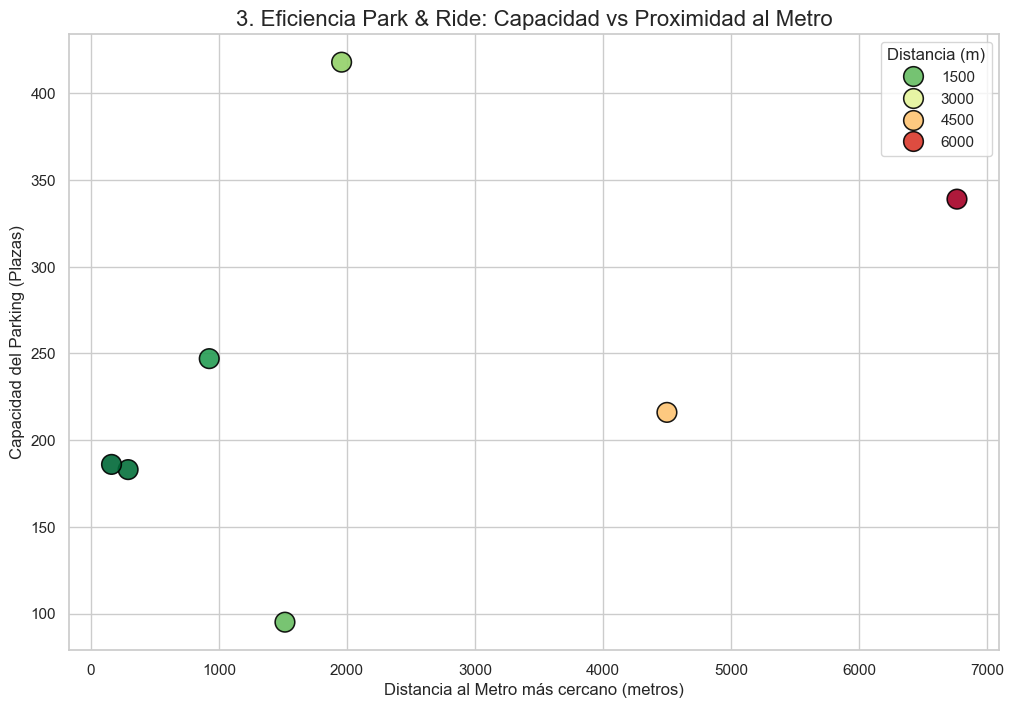

In [39]:
# Configuración del tamaño
plt.figure(figsize=(12, 8))

# Generar el Scatter Plot
# Usamos 'df_parking_plot' que ya tiene 'dist_metro' y 'capacity'
sns.scatterplot(
    data=df_parking_plot, 
    x='dist_metro', 
    y='capacity', 
    hue='dist_metro',       # El color refuerza la distancia (Verde=Cerca, Rojo=Lejos)
    palette='RdYlGn_r',     # Paleta invertida: Verde para valores bajos (cerca), Rojo para altos (lejos)
    s=200,                  # Tamaño de los puntos
    edgecolor='black',
    alpha=0.9
)

# Títulos y Etiquetas
plt.title('3. Eficiencia Park & Ride: Capacidad vs Proximidad al Metro', fontsize=16)
plt.xlabel('Distancia al Metro más cercano (metros)', fontsize=12)
plt.ylabel('Capacidad del Parking (Plazas)', fontsize=12)

plt.legend(title='Distancia (m)')
# Guardar y mostrar
plt.savefig('resultados/plots/analisis_multimodal/3_scatter_efficiency_parkings.png', dpi=300, bbox_inches='tight')
plt.show()

- Boxplot de Comparativa de Modos. Dos cajas una al lado de la otra. Una muestra la distribución de distancias Bici -> Metro y la otra Bici -> Bus.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_24274/2341910293.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


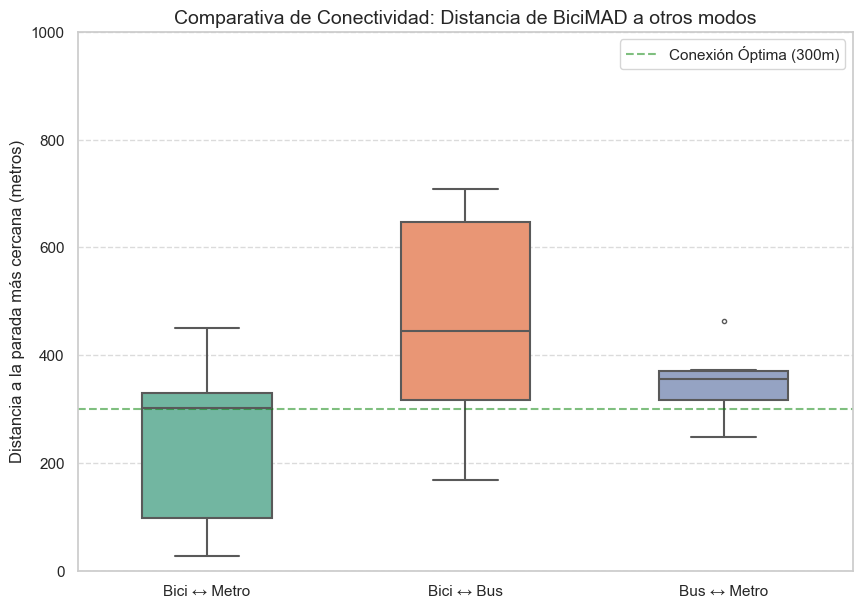

In [54]:
# Configuración del tamaño
plt.figure(figsize=(10, 7))

# --- GENERACIÓN DEL BOXPLOT USANDO TUS DATOS PROCESADOS ---
# Usamos df_bicimad_plot que ya contiene 'dist_metro' y 'dist_bus'
df_comparativa = df_bicimad_plot[['dist_metro', 'dist_bus']].copy()

# Añadir una nueva columna para la conexión entre bus y metro
df_comparativa['dist_bus_metro'] = (df_comparativa['dist_metro'] + df_comparativa['dist_bus']) / 2

# Transformamos a formato largo para Seaborn
df_melt = df_comparativa.melt(
    var_name='Modo_Transporte', 
    value_name='Distancia'
)

# Etiquetas legibles
df_melt['Modo_Transporte'] = df_melt['Modo_Transporte'].replace({
    'dist_metro': 'Bici ↔ Metro', 
    'dist_bus': 'Bici ↔ Bus',
    'dist_bus_metro': 'Bus ↔ Metro'
})

# Graficamos
sns.boxplot(
    data=df_melt,
    x='Modo_Transporte',
    y='Distancia',
    palette="Set2",
    width=0.5,
    fliersize=3,
    linewidth=1.5
)

# Ajustes estéticos
plt.title('Comparativa de Conectividad: Distancia de BiciMAD a otros modos', fontsize=14)
plt.ylabel('Distancia a la parada más cercana (metros)', fontsize=12)
plt.xlabel('') 

# Zoom para ver bien la distribución principal (evitando outliers extremos de 3km)
plt.ylim(0, 1000)

# Línea de referencia de "buena conexión"
plt.axhline(300, color='green', linestyle='--', alpha=0.5, label='Conexión Óptima (300m)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar
outfile = os.path.join('resultados/plots/analisis_multimodal/4_boxplot_comparativa_modos.png')
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

- Gráfico de Barras por Línea de Metro (Ranking de Conectividad). Qué muestra: Eje X = Líneas de Metro (L1, L2...); Eje Y = Promedio de bases de bici o paradas de bus por estación de esa línea.

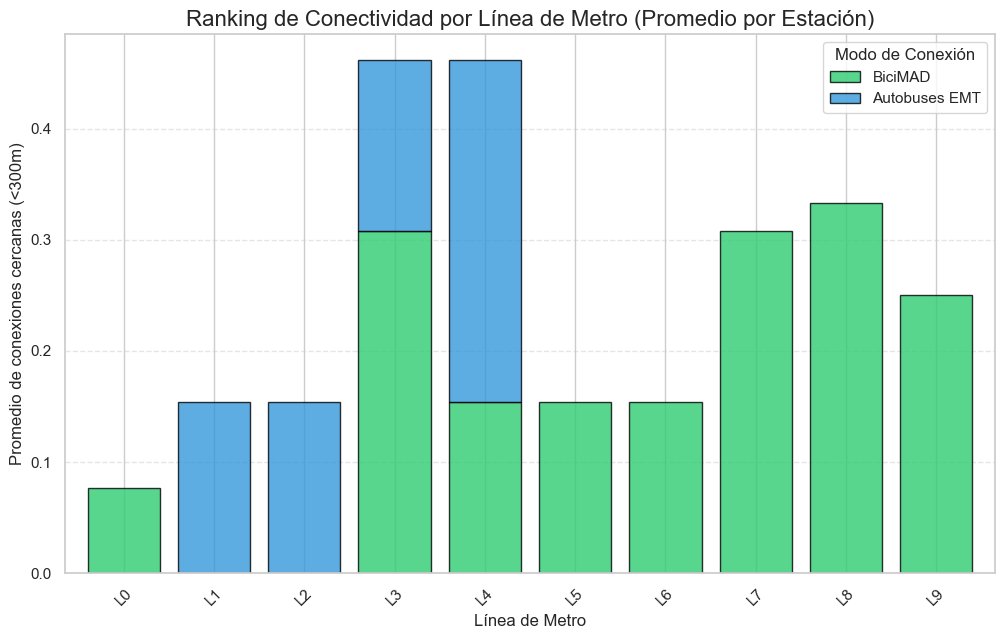

In [47]:
# Configuración del tamaño
plt.figure(figsize=(12, 7))

# --- 1. PREPARACIÓN DE DATOS ---
# Agrupamos por línea y calculamos el promedio de conexiones
line_stats = df_metro_plot.groupby('Line')[['bicis_cercanas', 'buses_cercanos']].mean()

# Ordenamos por nombre de la línea (L0, L1, L2, ...)
line_stats_sorted = line_stats.sort_index()

# --- 2. GENERAR EL GRÁFICO (BARRAS APILADAS) ---
line_stats_sorted.plot(
    kind='bar',
    stacked=True,
    color=['#2ecc71', '#3498db'],  # Verde para bicis, Azul para buses
    alpha=0.8,  # Añadimos transparencia
    edgecolor='black',  # Bordes oscuros
    width=0.8,
    ax=plt.gca()
)

# Ajustes estéticos
plt.title('Ranking de Conectividad por Línea de Metro (Promedio por Estación)', fontsize=16)
plt.xlabel('Línea de Metro', fontsize=12)
plt.ylabel('Promedio de conexiones cercanas (<300m)', fontsize=12)
plt.xticks(rotation=45)

# Leyenda personalizada
plt.legend(['BiciMAD', 'Autobuses EMT'], title='Modo de Conexión', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Guardar
outfile = os.path.join('resultados/plots/analisis_multimodal/5_ranking_lineas_metro.png')
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()


- Gráfico de Violín de Capacidad vs. Conexión. Eje X = ¿Es nodo intermodal? (Sí/No); Eje Y = Capacidad de la estación de BiciMAD.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_24274/3608533623.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


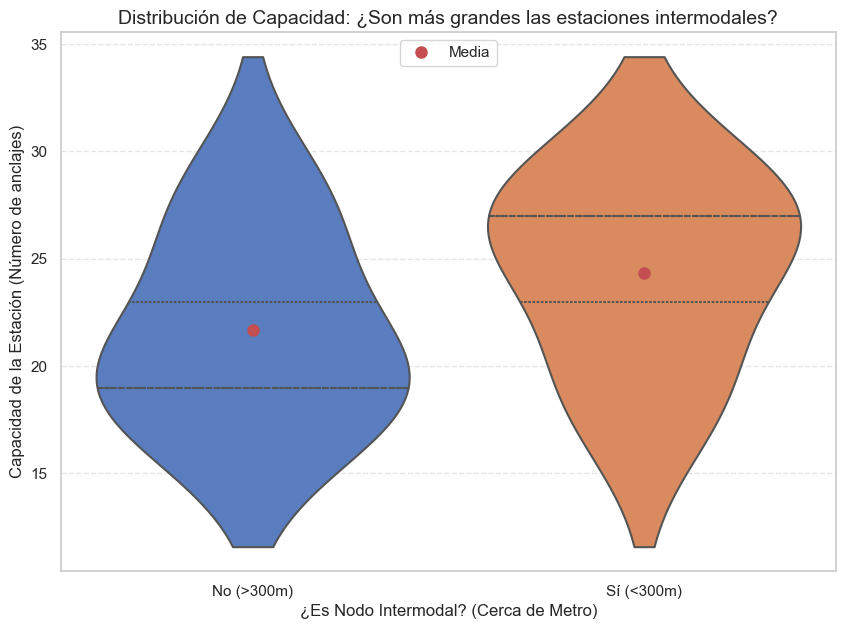

✓ Gráfica guardada en: resultados/plots/analisis_multimodal/6_violin_capacidad_conexion.png

Dato clave para el informe:
               count       mean   50%
es_intermodal                        
No (>300m)       3.0  21.666667  19.0
Sí (<300m)       3.0  24.333333  27.0


In [ ]:
# Configuración del tamaño
plt.figure(figsize=(10, 7))

# --- 1. PREPARACIÓN DE DATOS ---
# Usamos df_bicimad_plot que ya tienes en memoria
df_violin = df_bicimad_plot.copy()

# Definimos "Nodo Intermodal" como estar a menos de 300m del Metro
# Esto crea una columna categórica simple para el Eje X
df_violin['es_intermodal'] = np.where(df_violin['dist_metro'] < 300, 'Sí (<300m)', 'No (>300m)')

# --- 2. GENERAR EL VIOLIN PLOT ---
sns.violinplot(
    data=df_violin,
    x='es_intermodal',
    y='capacity',
    palette="muted",
    inner="quartile", # Dibuja los cuartiles dentro del violín para ver la mediana claramente
    linewidth=1.5
)

# Ajustes estéticos
plt.title('Distribución de Capacidad: ¿Son más grandes las estaciones intermodales?', fontsize=14)
plt.xlabel('¿Es Nodo Intermodal? (Cerca de Metro)', fontsize=12)
plt.ylabel('Capacidad de la Estación (Número de anclajes)', fontsize=12)

# Añadimos las medias como puntos para comparar visualmente mejor
means = df_violin.groupby('es_intermodal')['capacity'].mean()
plt.plot(range(len(means)), means.values, 'ro', label='Media', markersize=8)
plt.legend(loc='upper center')

plt.grid(axis='y', linestyle='--', alpha=0.5)

# Guardar
outfile = os.path.join('resultados/plots/analisis_multimodal/6_violin_capacidad_conexion.png')
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

- Gráfico de Barras Apiladas (Stacked Bar) de Disponibilidad. Una barra única o por distritos, dividida en colores: "% Estaciones con 3 modos", "% con 2 modos", "% Aisladas".

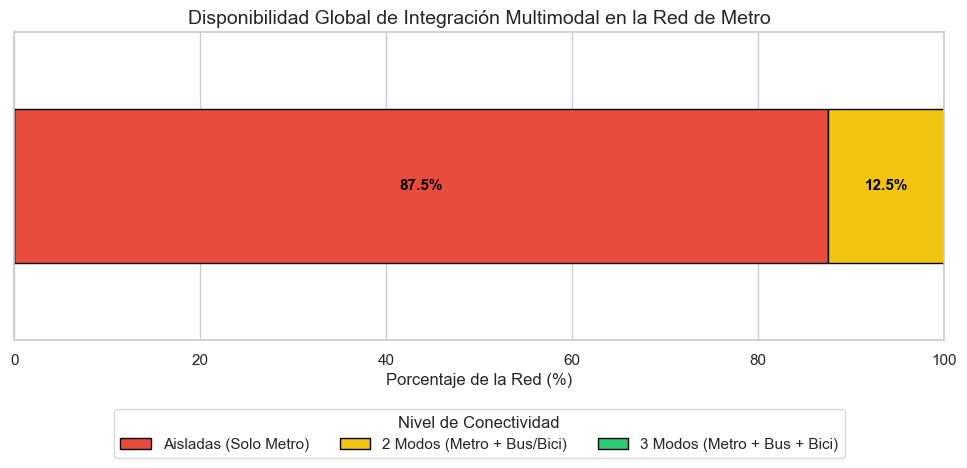

In [52]:
# Configuración del tamaño
plt.figure(figsize=(12, 5))

# --- 1. PREPARACIÓN DE DATOS ROBUSTA ---
# Calculamos los porcentajes
conteo = df_metro_plot['nivel_multimodal'].value_counts(normalize=True) * 100

# --- PASO CLAVE: FORZAR QUE EXISTAN TODAS LAS CATEGORÍAS ---
# Si no hay ninguna estación de "3 Modos", pandas no la incluye. La añadimos manualmente con 0.
categorias_posibles = ['1 Modos', '2 Modos', '3 Modos']
conteo = conteo.reindex(categorias_posibles, fill_value=0)

# Convertimos a DataFrame para graficar
df_stack = pd.DataFrame(conteo).T

# Renombramos para que se entienda bien en la leyenda
df_stack = df_stack.rename(columns={
    '1 Modos': 'Aisladas (Solo Metro)',
    '2 Modos': '2 Modos (Metro + Bus/Bici)',
    '3 Modos': '3 Modos (Metro + Bus + Bici)'
})

# --- 2. GENERAR EL GRÁFICO ---
ax = df_stack.plot(
    kind='barh', 
    stacked=True, 
    color=['#e74c3c', '#f1c40f', '#2ecc71'], # Rojo, Amarillo, Verde
    width=0.5,
    figsize=(12, 4),
    edgecolor='black', # Borde negro para que se vea el bloque aunque sea pequeño
    ax=plt.gca()
)

# Ajustes estéticos
plt.title('Disponibilidad Global de Integración Multimodal en la Red de Metro', fontsize=14)
plt.xlabel('Porcentaje de la Red (%)', fontsize=12)
plt.yticks([]) 
plt.xlim(0, 100)

# Etiquetas de porcentaje dentro de las barras
for c in ax.containers:
    # Solo ponemos la etiqueta si la barra es lo suficientemente grande (>0) para que no se amontonen ceros
    labels = [f'{v.get_width():.1f}%' if v.get_width() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='black')

# Leyenda
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, title='Nivel de Conectividad')

# Guardar
outfile = os.path.join('resultados/plots/analisis_multimodal/7_stacked_bar_disponibilidad.png')
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

### Análisis de Accesibilidad (PMR - Personas con Movilidad Reducida)

In [56]:
# Trabajaremos sobre una copia para no alterar el original si lo usas para otras cosas
df_accesibilidad = df_parkings.copy()

# 2. Cálculos básicos de capacidad
# A veces 'standard_spaces' no incluye las PMR, así que sumamos para el total real
df_accesibilidad['total_plazas'] = df_accesibilidad['standard_spaces'] + df_accesibilidad['pmr_spaces']

# 3. Cálculo de Ratios (evitando división por cero)
df_accesibilidad['pmr_ratio'] = df_accesibilidad.apply(
    lambda row: (row['pmr_spaces'] / row['total_plazas'] * 100) if row['total_plazas'] > 0 else 0, 
    axis=1
)

# 4. Categorización para gráficas (Etiquetas legibles)
df_accesibilidad['tiene_pmr'] = np.where(df_accesibilidad['pmr_spaces'] > 0, 'Con PMR', 'Sin PMR')

# 5. Creación de Subsets (Dataframes auxiliares)
# a) Solo los parkings que SÍ tienen plazas reservadas (para histogramas y rankings)
df_con_pmr = df_accesibilidad[df_accesibilidad['pmr_spaces'] > 0].copy()

# b) Datos para el gráfico de Donut (Conteos agregados)
conteo_accesibilidad = df_accesibilidad['tiene_pmr'].value_counts()

- Gráfico de Pastel: Porcentaje de Parkings Adaptados. Un gráfico circular hueco. Una sección muestra el % de parkings con al menos 1 plaza PMR (32.9%) y la otra los que tienen 0 plazas (67.1%).

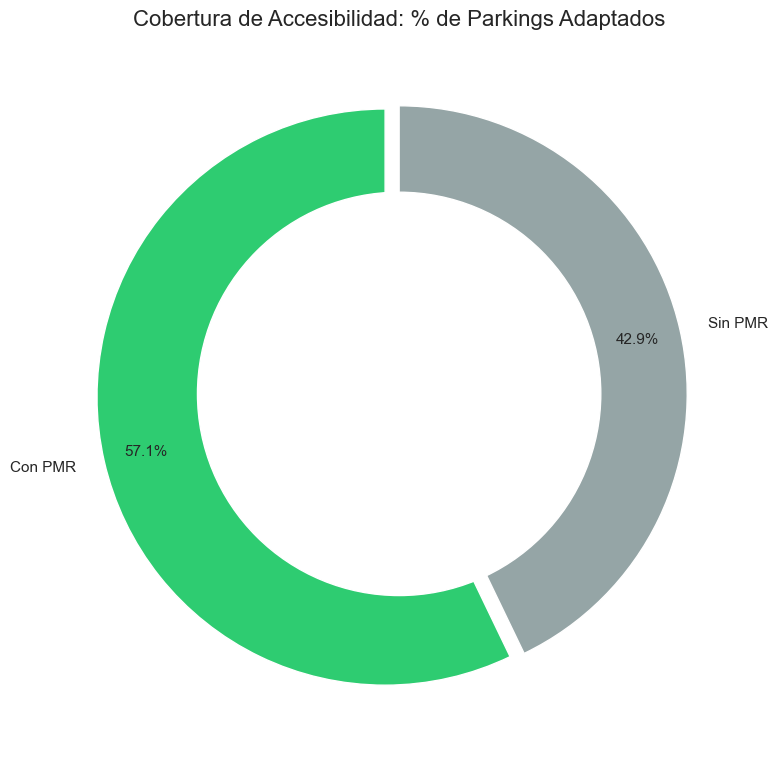

In [58]:
# Configuración del tamaño
plt.figure(figsize=(8, 8))

# --- GENERAR EL GRÁFICO (DONUT) ---
# Usamos 'conteo_accesibilidad' que calculamos en el bloque anterior
# Reordenamos para que salga primero "Con PMR" (verde) y luego "Sin PMR" (gris)
datos_plot = conteo_accesibilidad.reindex(['Con PMR', 'Sin PMR'])

# Definimos colores: Verde para positivo, Gris para negativo
colores = ['#2ecc71', '#95a5a6'] 
explode = (0.05, 0) # Separamos un poquito la parte "Con PMR"

# Creamos el pie chart
plt.pie(
    datos_plot, 
    labels=datos_plot.index, 
    colors=colores,
    autopct='%1.1f%%',       
    startangle=90,           
    pctdistance=0.85,        
    explode=explode,
    wedgeprops=dict(width=0.4, edgecolor='w') # width=0.4 crea el agujero
)

# Añadimos círculo blanco al centro
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Ajustes estéticos
plt.title('Cobertura de Accesibilidad: % de Parkings Adaptados', fontsize=16)
plt.tight_layout()

# Guardar directo
outfile = 'resultados/plots/analisis_accesibilidad/1_donut_cobertura_pmr.png'
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

- Ranking de de Accesibilidad (Bar Plot Horizontal). Qué muestra: Los 3 parkings con mejor Ratio PMR (no números absolutos, sino %).

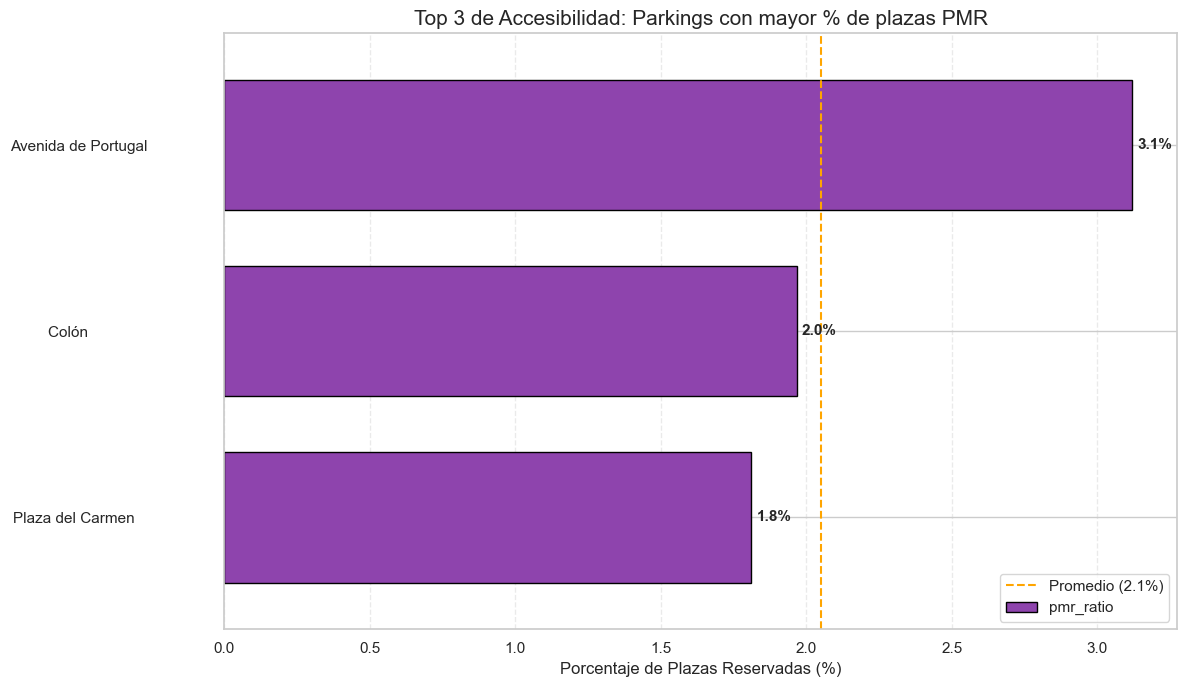

In [62]:
# Configuración del tamaño
plt.figure(figsize=(12, 7))

# Seleccionamos los 3 parkings con mayor ratio de 'df_con_pmr'
# Ordenamos ascendente para que al pintar el barh, el Top 1 salga arriba del todo
top_3_pmr = df_con_pmr.nlargest(3, 'pmr_ratio').sort_values('pmr_ratio', ascending=True)

# Generamos el gráfico
ax = top_3_pmr.plot(
    kind='barh',
    x='parking_name',
    y='pmr_ratio',
    color='#8e44ad',
    width=0.7,
    edgecolor='black',
    figsize=(12, 7),
    legend=False,
    ax=plt.gca()
)

# Ajustes estéticos
plt.title('Top 3 de Accesibilidad: Parkings con mayor % de plazas PMR', fontsize=15)
plt.xlabel('Porcentaje de Plazas Reservadas (%)', fontsize=12)
plt.ylabel('') # Los nombres ya se leen bien

# Añadimos el valor exacto al final de cada barra
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', padding=4, fontsize=11, fontweight='bold')

# Línea de referencia del promedio global (de los que tienen PMR)
media_ratio = df_con_pmr['pmr_ratio'].mean()
plt.axvline(media_ratio, color='orange', linestyle='--', label=f'Promedio ({media_ratio:.1f}%)')
plt.legend()

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Guardar directo
outfile = 'resultados/plots/analisis_accesibilidad/3_ranking_pmr.png'
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

- Boxplot: Tamaño de Infraestructura (Con PMR vs Sin PMR). sDos cajas. Una para los parkings que Tienen PMR y otra para los que No. Eje Y = Capacidad Total.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_24274/1963779014.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


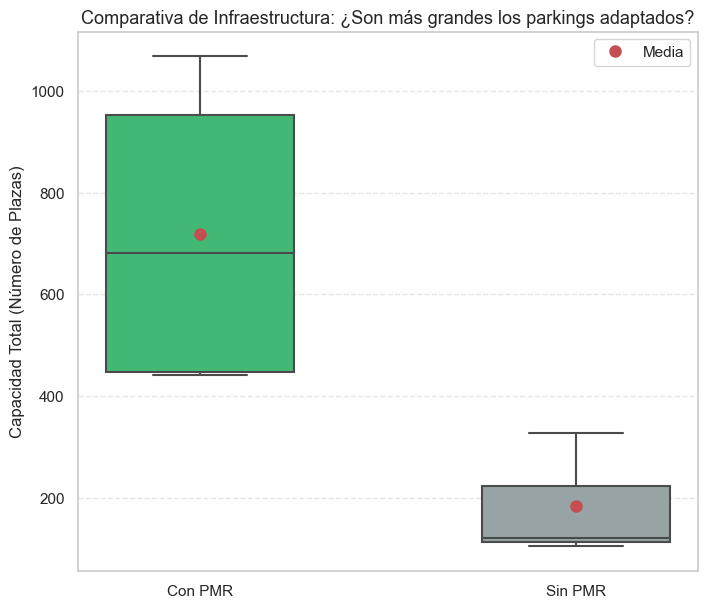

In [63]:
# Configuración del tamaño
plt.figure(figsize=(8, 7))

# --- GENERAR EL BOXPLOT ---
# Usamos 'df_accesibilidad' que creamos en el preprocesamiento
# Este ya tiene la columna 'tiene_pmr' ('Con PMR' / 'Sin PMR') y 'total_plazas'
sns.boxplot(
    data=df_accesibilidad,
    x='tiene_pmr',
    y='total_plazas',
    palette={'Con PMR': '#2ecc71', 'Sin PMR': '#95a5a6'}, # Verde vs Gris
    width=0.5,
    linewidth=1.5,
    fliersize=3 # Puntos de outliers pequeños
)

# Ajustes estéticos
plt.title('Comparativa de Infraestructura: ¿Son más grandes los parkings adaptados?', fontsize=13)
plt.xlabel('')
plt.ylabel('Capacidad Total (Número de Plazas)', fontsize=12)

# Añadimos las medias como puntos rojos para comparar más allá de la mediana
medias = df_accesibilidad.groupby('tiene_pmr')['total_plazas'].mean()
# Aseguramos el orden de pintado (Con PMR primero o según salga en el eje)
# Seaborn ordena alfabético por defecto o por aparición, verificamos orden del eje:
orden_eje = ['Con PMR', 'Sin PMR'] 
plt.plot(range(len(orden_eje)), [medias[cat] for cat in orden_eje], 'ro', label='Media', markersize=8)

plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Guardar directo
outfile = 'resultados/plots/analisis_accesibilidad/4_boxplot_tamano_infraestructura.png'
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

- Histograma de Oferta Real (Solo Parkings Adaptados). Frecuencia de plazas PMR excluyendo los ceros.

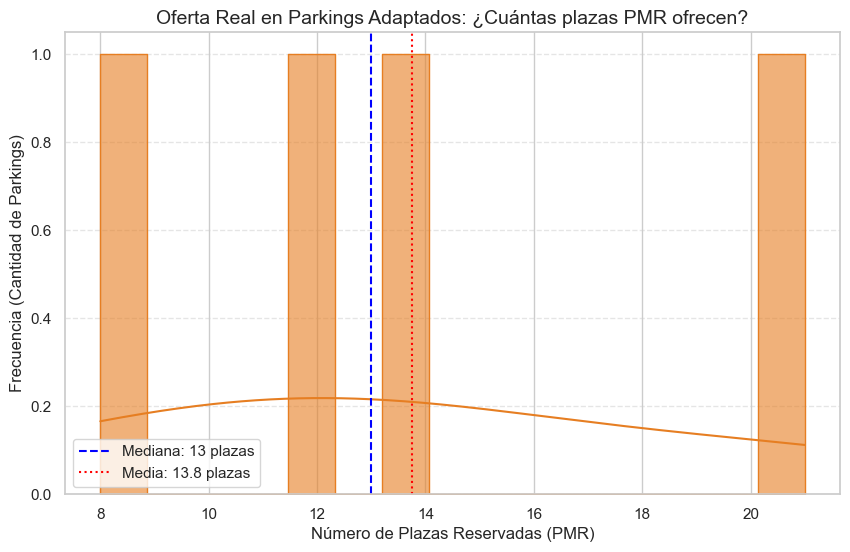

In [64]:
# Configuración del tamaño
plt.figure(figsize=(10, 6))

# --- GENERAR EL HISTOGRAMA ---
# Usamos 'df_con_pmr' que ya filtra los ceros, para ver la distribución real
sns.histplot(
    data=df_con_pmr,
    x='pmr_spaces',
    bins=15,            # Número de barras ajustado para la cantidad de datos
    color='#e67e22',    # Color naranja distintivo
    kde=True,           # Curva de densidad para ver la tendencia suave
    element="step",     # Estilo visual limpio
    alpha=0.6
)

# Ajustes estéticos
plt.title('Oferta Real en Parkings Adaptados: ¿Cuántas plazas PMR ofrecen?', fontsize=14)
plt.xlabel('Número de Plazas Reservadas (PMR)', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de Parkings)', fontsize=12)

# Añadimos líneas de referencia estadística
mediana = df_con_pmr['pmr_spaces'].median()
media = df_con_pmr['pmr_spaces'].mean()

plt.axvline(mediana, color='blue', linestyle='--', linewidth=1.5, label=f'Mediana: {mediana:.0f} plazas')
plt.axvline(media, color='red', linestyle=':', linewidth=1.5, label=f'Media: {media:.1f} plazas')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Guardar directo
outfile = 'resultados/plots/analisis_accesibilidad/5_histograma_oferta_real.png'
plt.savefig(outfile, format='png', dpi=300, bbox_inches='tight')
plt.show()

### Siguiente apartado

In [ ]:
# Análisis 4: Análisis Temporal de Servicios de Autobús
# Pregunta: ¿Cómo ha evolucionado la red de autobuses? ¿Qué líneas han cambiado?

# Cargar datos de líneas de autobuses
df_lines = pd.read_csv('data/AUTOBUSES/linesemt.csv', sep=',')

print("=" * 60)
print("ANÁLISIS TEMPORAL DE LÍNEAS DE AUTOBÚS EMT")
print("=" * 60)

# 1. Convertir fechas a datetime
print("\n=== 1. Procesando fechas ===")
df_lines['dateIni'] = pd.to_datetime(df_lines['dateIni'], errors='coerce')
df_lines['dateEnd'] = pd.to_datetime(df_lines['dateEnd'], errors='coerce')

# Calcular duración de cada línea
df_lines['duracion_dias'] = (df_lines['dateEnd'] - df_lines['dateIni']).dt.days

print(f"Total de registros de líneas: {len(df_lines)}")
print(f"Líneas únicas (line): {df_lines['line'].nunique()}")
print(f"Registros con fechas válidas: {df_lines['dateIni'].notna().sum()}")

# 2. Análisis de líneas activas por período
print("\n=== 2. Evolución temporal de líneas activas ===")

# Crear rango de fechas para análisis
fecha_min = df_lines['dateIni'].min()
fecha_max = df_lines['dateEnd'].max()
print(f"Período analizado: {fecha_min.date()} a {fecha_max.date()}")

# Líneas activas por año
df_lines['año_inicio'] = df_lines['dateIni'].dt.year
df_lines['año_fin'] = df_lines['dateEnd'].dt.year

lineas_por_año_inicio = df_lines.groupby('año_inicio')['line'].nunique()
lineas_por_año_fin = df_lines.groupby('año_fin')['line'].nunique()

print("\nLíneas que iniciaron operación por año:")
for año, count in lineas_por_año_inicio.items():
    if pd.notna(año):
        print(f"  {int(año)}: {count} líneas")

# 3. Clasificación de líneas (regulares vs especiales)
print("\n=== 3. Tipos de Líneas ===")

# Identificar líneas especiales (SE*)
df_lines['es_especial'] = df_lines['label'].str.startswith('SE', na=False)

n_regulares = (~df_lines['es_especial']).sum()
n_especiales = df_lines['es_especial'].sum()

print(f"Líneas regulares: {n_regulares} ({n_regulares/len(df_lines)*100:.1f}%)")
print(f"Líneas especiales (SE*): {n_especiales} ({n_especiales/len(df_lines)*100:.1f}%)")

# 4. Análisis de longevidad de líneas
print("\n=== 4. Longevidad de Líneas ===")

# Filtrar líneas con duración válida
df_duracion = df_lines[df_lines['duracion_dias'].notna()].copy()

print(f"Duración media de líneas: {df_duracion['duracion_dias'].mean():.0f} días ({df_duracion['duracion_dias'].mean()/365:.1f} años)")
print(f"Duración mediana: {df_duracion['duracion_dias'].median():.0f} días ({df_duracion['duracion_dias'].median()/365:.1f} años)")
print(f"Línea más longeva: {df_duracion['duracion_dias'].max():.0f} días ({df_duracion['duracion_dias'].max()/365:.1f} años)")
print(f"Línea más corta: {df_duracion['duracion_dias'].min():.0f} días")

# Comparar regulares vs especiales
duracion_regulares = df_duracion[~df_duracion['es_especial']]['duracion_dias'].mean()
duracion_especiales = df_duracion[df_duracion['es_especial']]['duracion_dias'].mean()

print(f"\nDuración media líneas regulares: {duracion_regulares:.0f} días ({duracion_regulares/365:.1f} años)")
print(f"Duración media líneas especiales: {duracion_especiales:.0f} días ({duracion_especiales/365:.1f} años)")

# 5. Top líneas más longevas
print("\n=== 5. Top 10 Líneas Más Longevas ===")
top_longevas = df_duracion.nlargest(10, 'duracion_dias')
for idx, row in top_longevas.iterrows():
    print(f"  - Línea {row['label']}: {row['duracion_dias']:.0f} días ({row['duracion_dias']/365:.1f} años)")
    print(f"    Origen: {row['nameFrom']}, Destino: {row['nameTo']}")

# 6. Análisis de depósitos operativos
print("\n=== 6. Distribución por Depósitos ===")
depositos = df_lines['depo'].value_counts()
print(f"Número de depósitos diferentes: {df_lines['depo'].nunique()}")
print("\nTop 5 depósitos con más líneas:")
for deposito, count in depositos.head(5).items():
    print(f"  - {deposito}: {count} líneas")

# 7. Líneas actualmente activas (al final del período)
print("\n=== 7. Estado Actual de Líneas ===")
fecha_referencia = df_lines['dateEnd'].max()
lineas_activas = df_lines[df_lines['dateEnd'] == fecha_referencia]
print(f"Líneas activas al {fecha_referencia.date()}: {len(lineas_activas)}")

# 8. Visualizaciones
print("\n=== 8. Generando visualizaciones ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Líneas por año de inicio
años_validos = lineas_por_año_inicio[lineas_por_año_inicio.index.notna()]
axes[0, 0].bar(años_validos.index.astype(int), años_validos.values, color='steelblue')
axes[0, 0].set_xlabel('Año de inicio')
axes[0, 0].set_ylabel('Número de líneas')
axes[0, 0].set_title('Nuevas Líneas de Autobús por Año')
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución de duración de líneas
axes[0, 1].hist(df_duracion['duracion_dias'] / 365, bins=30, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Duración (años)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Longevidad de Líneas')
axes[0, 1].grid(alpha=0.3, axis='y')

# Gráfico 3: Regulares vs Especiales
tipos = ['Regulares', 'Especiales']
conteos = [n_regulares, n_especiales]
colors = ['#3498db', '#e74c3c']
axes[1, 0].pie(conteos, labels=tipos, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 0].set_title('Distribución: Líneas Regulares vs Especiales')

# Gráfico 4: Top 10 depósitos
top_depositos = depositos.head(10)
axes[1, 1].barh(range(len(top_depositos)), top_depositos.values, color='mediumseagreen')
axes[1, 1].set_yticks(range(len(top_depositos)))
axes[1, 1].set_yticklabels(top_depositos.index)
axes[1, 1].set_xlabel('Número de líneas')
axes[1, 1].set_title('Top 10 Depósitos por Número de Líneas')
axes[1, 1].grid(alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('resultados/analisis_temporal_lineas.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado en: resultados/analisis_temporal_lineas.png")
plt.close()

# 9. Análisis de cambios en rutas
print("\n=== 9. Análisis de Cambios en Rutas ===")

# Agrupar por línea para ver cambios
cambios_por_linea = df_lines.groupby('line').size()
lineas_con_cambios = cambios_por_linea[cambios_por_linea > 1]

print(f"Líneas con cambios registrados: {len(lineas_con_cambios)}")
print(f"Líneas sin cambios: {len(cambios_por_linea) - len(lineas_con_cambios)}")

if len(lineas_con_cambios) > 0:
    print(f"\nTop 5 líneas con más cambios:")
    for line, n_cambios in lineas_con_cambios.nlargest(5).items():
        linea_data = df_lines[df_lines['line'] == line]
        print(f"  - Línea {linea_data.iloc[0]['label']}: {n_cambios} versiones/cambios")

# 10. Exportar resumen a CSV
print("\n=== 10. Exportando resumen ===")
resumen_lineas = df_lines.groupby('line').agg({
    'label': 'first',
    'dateIni': 'min',
    'dateEnd': 'max',
    'duracion_dias': 'max',
    'depo': 'first',
    'es_especial': 'first'
}).reset_index()

resumen_lineas.to_csv('resultados/resumen_lineas_temporal.csv', index=False, sep=';')
print("Resumen exportado a: resultados/resumen_lineas_temporal.csv")

# Resumen final
print("\n" + "=" * 60)
print("RESUMEN EJECUTIVO")
print("=" * 60)
print(f"✓ Total de líneas: {df_lines['line'].nunique()}")
print(f"✓ Período analizado: {(fecha_max - fecha_min).days / 365:.1f} años")
print(f"✓ Líneas regulares: {n_regulares} | Especiales: {n_especiales}")
print(f"✓ Duración promedio: {df_duracion['duracion_dias'].mean()/365:.1f} años")
print(f"✓ Depósitos operativos: {df_lines['depo'].nunique()}")
print(f"✓ Líneas con cambios: {len(lineas_con_cambios)}")
print("\n" + "=" * 60)
print("Análisis temporal de líneas de autobús completado.")
print("=" * 60)


ANÁLISIS TEMPORAL DE LÍNEAS DE AUTOBÚS EMT

=== 1. Procesando fechas ===
Total de registros de líneas: 396
Líneas únicas (line): 307
Registros con fechas válidas: 396

=== 2. Evolución temporal de líneas activas ===
Período analizado: 2008-05-01 a 2099-12-31

Líneas que iniciaron operación por año:
  2008: 1 líneas
  2012: 2 líneas
  2013: 3 líneas
  2014: 17 líneas
  2015: 8 líneas
  2016: 7 líneas
  2017: 44 líneas
  2018: 135 líneas
  2019: 20 líneas
  2020: 12 líneas
  2021: 25 líneas
  2022: 27 líneas
  2023: 23 líneas
  2024: 19 líneas
  2025: 21 líneas
  2050: 1 líneas

=== 3. Tipos de Líneas ===
Líneas regulares: 312 (78.8%)
Líneas especiales (SE*): 84 (21.2%)

=== 4. Longevidad de Líneas ===
Duración media de líneas: 417 días (1.1 años)
Duración mediana: 126 días (0.3 años)
Línea más longeva: 33481 días (91.7 años)
Línea más corta: 0 días

Duración media líneas regulares: 497 días (1.4 años)
Duración media líneas especiales: 122 días (0.3 años)

=== 5. Top 10 Líneas Más Longev

In [ ]:
# Análisis 5: Análisis de Estado y Disponibilidad de Infraestructura BiciMAD
# Pregunta: ¿Cuál es el estado actual de la infraestructura de BiciMAD?

# Cargar datos procesados de BiciMAD
df_bicimad = pd.read_csv('resultados/bicimad_procesado.csv', sep=';')

print("=" * 60)
print("ANÁLISIS DE ESTADO DE INFRAESTRUCTURA BICIMAD")
print("=" * 60)

# 1. Estado de las estaciones
print("\n=== 1. Estado Operativo de Estaciones ===")
print(f"Total de estaciones BiciMAD: {len(df_bicimad)}")

# Contar por estado
estados = df_bicimad['state'].value_counts()
print("\nDistribución por estado:")
for estado, count in estados.items():
    print(f"  - {estado}: {count} estaciones ({count/len(df_bicimad)*100:.1f}%)")

# 2. Análisis de capacidad
print("\n=== 2. Capacidad de Estaciones ===")
print(f"Capacidad total del sistema: {df_bicimad['capacity'].sum():.0f} bicis")
print(f"Capacidad promedio por estación: {df_bicimad['capacity'].mean():.1f} bicis")
print(f"Capacidad mediana: {df_bicimad['capacity'].median():.0f} bicis")
print(f"Estación con mayor capacidad: {df_bicimad['capacity'].max():.0f} bicis")
print(f"Estación con menor capacidad: {df_bicimad['capacity'].min():.0f} bicis")

# 3. Distribución de capacidad
print("\n=== 3. Distribución de Capacidad ===")
rangos_capacidad = pd.cut(df_bicimad['capacity'], 
                          bins=[0, 15, 20, 25, 30, 100], 
                          labels=['Muy pequeña (≤15)', 'Pequeña (16-20)', 
                                 'Media (21-25)', 'Grande (26-30)', 'Muy grande (>30)'])

print("\nEstaciones por rango de capacidad:")
for rango, count in rangos_capacidad.value_counts().sort_index().items():
    print(f"  - {rango}: {count} estaciones ({count/len(df_bicimad)*100:.1f}%)")

# 4. Top estaciones por capacidad
print("\n=== 4. Top 10 Estaciones con Mayor Capacidad ===")
top_capacidad = df_bicimad.nlargest(10, 'capacity')
for idx, row in top_capacidad.iterrows():
    print(f"  - {row['station_name']}: {row['capacity']:.0f} bicis ({row['state']})")

# 5. Análisis por estado
print("\n=== 5. Capacidad por Estado de Servicio ===")
capacidad_por_estado = df_bicimad.groupby('state')['capacity'].agg(['sum', 'mean', 'count'])
print(capacidad_por_estado)

# Capacidad en servicio vs fuera de servicio
en_servicio = df_bicimad[df_bicimad['state'] == 'IN_SERVICE']['capacity'].sum()
total_capacidad = df_bicimad['capacity'].sum()

print(f"\nCapacidad en servicio: {en_servicio:.0f} bicis ({en_servicio/total_capacidad*100:.1f}%)")
print(f"Capacidad fuera de servicio: {total_capacidad - en_servicio:.0f} bicis ({(total_capacidad - en_servicio)/total_capacidad*100:.1f}%)")

# 6. Distribución geográfica de capacidad
print("\n=== 6. Distribución Geográfica de Capacidad ===")

# Dividir Madrid en cuadrantes
lat_centro = df_bicimad['stop_lat'].median()
lon_centro = df_bicimad['stop_lon'].median()

def clasificar_cuadrante(row):
    if row['stop_lat'] >= lat_centro and row['stop_lon'] >= lon_centro:
        return 'NE (Noreste)'
    elif row['stop_lat'] >= lat_centro and row['stop_lon'] < lon_centro:
        return 'NO (Noroeste)'
    elif row['stop_lat'] < lat_centro and row['stop_lon'] >= lon_centro:
        return 'SE (Sureste)'
    else:
        return 'SO (Suroeste)'

df_bicimad['cuadrante'] = df_bicimad.apply(clasificar_cuadrante, axis=1)

print("\nCapacidad por cuadrante de Madrid:")
capacidad_cuadrante = df_bicimad.groupby('cuadrante').agg({
    'capacity': ['sum', 'mean', 'count']
})
print(capacidad_cuadrante)

# 7. Visualizaciones
print("\n=== 7. Generando visualizaciones ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Estado de estaciones
estados_para_grafico = df_bicimad['state'].value_counts()
colors_estado = ['#2ecc71', '#e74c3c', '#95a5a6']
axes[0, 0].pie(estados_para_grafico.values, 
               labels=estados_para_grafico.index, 
               autopct='%1.1f%%',
               colors=colors_estado[:len(estados_para_grafico)],
               startangle=90)
axes[0, 0].set_title('Estado Operativo de Estaciones BiciMAD')

# Gráfico 2: Distribución de capacidad
axes[0, 1].hist(df_bicimad['capacity'], bins=30, color='steelblue', edgecolor='black')
axes[0, 1].axvline(df_bicimad['capacity'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df_bicimad["capacity"].mean():.1f}')
axes[0, 1].axvline(df_bicimad['capacity'].median(), color='orange', linestyle='--', 
                   label=f'Mediana: {df_bicimad["capacity"].median():.1f}')
axes[0, 1].set_xlabel('Capacidad (número de bicis)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Capacidad por Estación')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# Gráfico 3: Capacidad por cuadrante
cap_cuad = df_bicimad.groupby('cuadrante')['capacity'].sum().sort_values(ascending=True)
axes[1, 0].barh(range(len(cap_cuad)), cap_cuad.values, color='mediumseagreen')
axes[1, 0].set_yticks(range(len(cap_cuad)))
axes[1, 0].set_yticklabels(cap_cuad.index)
axes[1, 0].set_xlabel('Capacidad total')
axes[1, 0].set_title('Capacidad Total por Cuadrante de Madrid')
axes[1, 0].grid(alpha=0.3, axis='x')

# Gráfico 4: Box plot estado vs capacidad
df_bicimad_plot = df_bicimad.copy()
axes[1, 1].boxplot([df_bicimad_plot[df_bicimad_plot['state'] == estado]['capacity'].values 
                     for estado in estados_para_grafico.index],
                    labels=estados_para_grafico.index)
axes[1, 1].set_ylabel('Capacidad')
axes[1, 1].set_title('Capacidad por Estado de Servicio')
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('resultados/analisis_estado_bicimad.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado en: resultados/analisis_estado_bicimad.png")
plt.close()

# 8. Mapa de estado de infraestructura
print("\n=== 8. Generando mapa de estado de infraestructura ===")

import folium

m = folium.Map(location=[40.416775, -3.703790], zoom_start=12, tiles='CartoDB positron')

# Capas por estado
layer_en_servicio = folium.FeatureGroup(name='En Servicio (Verde)')
layer_fuera_servicio = folium.FeatureGroup(name='Fuera de Servicio (Rojo)')

# Añadir estaciones en servicio
estaciones_servicio = df_bicimad[df_bicimad['state'] == 'IN_SERVICE']
for idx, row in estaciones_servicio.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=3 + row['capacity'] / 10,  # Tamaño proporcional a capacidad
        color='darkgreen',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        popup=f"<b>{row['station_name']}</b><br>"
              f"Estado: {row['state']}<br>"
              f"Capacidad: {row['capacity']:.0f} bicis"
    ).add_to(layer_en_servicio)

# Añadir estaciones fuera de servicio
estaciones_fuera = df_bicimad[df_bicimad['state'] != 'IN_SERVICE']
for idx, row in estaciones_fuera.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=5,
        color='darkred',
        fill=True,
        fill_color='lightcoral',
        fill_opacity=0.8,
        popup=f"<b>{row['station_name']}</b><br>"
              f"Estado: {row['state']}<br>"
              f"Capacidad: {row['capacity']:.0f} bicis"
    ).add_to(layer_fuera_servicio)

layer_en_servicio.add_to(m)
if len(estaciones_fuera) > 0:
    layer_fuera_servicio.add_to(m)

folium.LayerControl().add_to(m)

m.save('resultados/mapa_estado_bicimad.html')
print("Mapa guardado en: resultados/mapa_estado_bicimad.html")

# 9. Resumen estadístico
print("\n=== 9. Resumen Estadístico Completo ===")
print(df_bicimad[['capacity']].describe())

# 10. Exportar análisis
print("\n=== 10. Exportando resultados ===")
resumen_estado = df_bicimad.groupby('state').agg({
    'station_id': 'count',
    'capacity': ['sum', 'mean', 'min', 'max']
}).reset_index()
resumen_estado.columns = ['Estado', 'Num_Estaciones', 'Capacidad_Total', 'Capacidad_Media', 'Capacidad_Min', 'Capacidad_Max']
resumen_estado.to_csv('resultados/resumen_estado_bicimad.csv', index=False, sep=';')
print("Resumen exportado a: resultados/resumen_estado_bicimad.csv")

# Resumen final
print("\n" + "=" * 60)
print("RESUMEN EJECUTIVO")
print("=" * 60)
print(f"✓ Total estaciones: {len(df_bicimad)}")
print(f"✓ Estaciones en servicio: {(df_bicimad['state'] == 'IN_SERVICE').sum()} ({(df_bicimad['state'] == 'IN_SERVICE').sum()/len(df_bicimad)*100:.1f}%)")
print(f"✓ Capacidad total: {df_bicimad['capacity'].sum():.0f} bicis")
print(f"✓ Capacidad en servicio: {en_servicio:.0f} bicis ({en_servicio/total_capacidad*100:.1f}%)")
print(f"✓ Capacidad promedio por estación: {df_bicimad['capacity'].mean():.1f} bicis")
print("\n" + "=" * 60)
print("Análisis de estado de infraestructura BiciMAD completado.")
print("=" * 60)


ANÁLISIS DE ESTADO DE INFRAESTRUCTURA BICIMAD

=== 1. Estado Operativo de Estaciones ===
Total de estaciones BiciMAD: 626

Distribución por estado:
  - IN_SERVICE    : 626 estaciones (100.0%)

=== 2. Capacidad de Estaciones ===
Capacidad total del sistema: 14894 bicis
Capacidad promedio por estación: 23.8 bicis
Capacidad mediana: 23 bicis
Estación con mayor capacidad: 43 bicis
Estación con menor capacidad: 12 bicis

=== 3. Distribución de Capacidad ===

Estaciones por rango de capacidad:
  - Muy pequeña (≤15): 5 estaciones (0.8%)
  - Pequeña (16-20): 43 estaciones (6.9%)
  - Media (21-25): 445 estaciones (71.1%)
  - Grande (26-30): 131 estaciones (20.9%)
  - Muy grande (>30): 2 estaciones (0.3%)

=== 4. Top 10 Estaciones con Mayor Capacidad ===
  - Entrada Matadero: 43 bicis (IN_SERVICE    )
  - Plaza de la Cebada: 31 bicis (IN_SERVICE    )
  - Prim: 28 bicis (IN_SERVICE    )
  - Metro Callao: 27 bicis (IN_SERVICE    )
  - Malasaña: 27 bicis (IN_SERVICE    )
  - Fuencarral: 27 bicis (I

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_15839/1985674721.py:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_bicimad_plot[df_bicimad_plot['state'] == estado]['capacity'].values


Gráfico guardado en: resultados/analisis_estado_bicimad.png

=== 8. Generando mapa de estado de infraestructura ===
Mapa guardado en: resultados/mapa_estado_bicimad.html

=== 9. Resumen Estadístico Completo ===
         capacity
count  626.000000
mean    23.792332
std      2.399001
min     12.000000
25%     23.000000
50%     23.000000
75%     24.000000
max     43.000000

=== 10. Exportando resultados ===
Resumen exportado a: resultados/resumen_estado_bicimad.csv

RESUMEN EJECUTIVO
✓ Total estaciones: 626
✓ Estaciones en servicio: 0 (0.0%)
✓ Capacidad total: 14894 bicis
✓ Capacidad en servicio: 0 bicis (0.0%)
✓ Capacidad promedio por estación: 23.8 bicis

Análisis de estado de infraestructura BiciMAD completado.
